In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
df4=pd.read_csv("C:/Users/FranciscoJosé/Documents/MySite/Crunia/Santa_Margarita_AM18.csv",sep=";", encoding="iso8859_15" ,parse_dates=[0],index_col=0,decimal='.')

In [3]:
# Convierte object en números
df4["NO2"]=pd.to_numeric(df4["NO2"],errors='coerce')

In [4]:
df4.dtypes

NO2    float64
dtype: object

In [5]:
df4.head()

,NO2
Fecha Lectura,
2018-01-01 01:00:00,7.5
2018-01-01 02:00:00,17.9
2018-01-01 03:00:00,10.9
2018-01-01 04:00:00,5.4
2018-01-01 05:00:00,2.5


In [6]:
df4.shape

(8753, 1)

In [7]:
df4['weekday']=[x.weekday() for x in df4.index]
df4['month']=[x.month for x in df4.index]
df4['hour']=[x.hour for x in df4.index]
df4.head(1)

,NO2,weekday,month,hour
Fecha Lectura,,,,
2018-01-01 01:00:00,7.5,0,1,1


In [8]:
df4.describe()

,NO2,weekday,month,hour
count,8724.000000,8753.000000,8753.000000,8753.000000
mean,22.776204,2.991888,6.525763,11.500628
std,17.771455,2.002981,3.446881,6.923025
min,0.400000,0.000000,1.000000,0.000000
25%,9.700000,1.000000,4.000000,6.000000
50%,17.500000,3.000000,7.000000,11.000000
75%,31.325000,5.000000,10.000000,18.000000
max,153.200000,6.000000,12.000000,23.000000


In [9]:
PASOS=10
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# load dataset
values = df4['NO2'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['hour']=df4['hour']
reframed['weekday']=df4['weekday']
reframed['month']=df4['month']


for i in range(reframed.index[0],reframed.index[-1]):
    reframed['hour'].loc[contador]=df4['hour'][i+25]
    reframed['weekday'].loc[contador]=df4['weekday'][i+8]
    reframed['month'].loc[contador]=df4['month'][i+13]
    contador=contador+1
reframed.head()

C:\Python\envs\Corunna\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
reordenado=reframed[ ['hour','weekday','month','var1(t-10)','var1(t-9)','var1(t-8)','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)','var1(t)'] ]
reordenado.dropna(inplace=True)
reordenado.head()

C:\Python\envs\Corunna\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,hour,weekday,month,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,2.0,4.0,10.0,-0.932115,-0.934726,-0.945170,-0.958225,-0.950392,-0.943864,-0.840731,-0.219321,-0.620104,-0.714099,-0.787206
1,3.0,4.0,10.0,-0.934726,-0.945170,-0.958225,-0.950392,-0.943864,-0.840731,-0.219321,-0.620104,-0.714099,-0.787206,-0.798956
2,4.0,4.0,10.0,-0.945170,-0.958225,-0.950392,-0.943864,-0.840731,-0.219321,-0.620104,-0.714099,-0.787206,-0.798956,-0.801567
3,5.0,4.0,10.0,-0.958225,-0.950392,-0.943864,-0.840731,-0.219321,-0.620104,-0.714099,-0.787206,-0.798956,-0.801567,-0.746736
4,6.0,4.0,10.0,-0.950392,-0.943864,-0.840731,-0.219321,-0.620104,-0.714099,-0.787206,-0.798956,-0.801567,-0.746736,-0.834204


In [21]:
training_data = reordenado.drop('var1(t)',axis=1)#.values
target_data=reordenado['var1(t)']
#training_data.head()
valid_data = training_data[4714-720:4714]
valid_target=target_data[4714-720:4714]

training_data = training_data[0:4714]
target_data=target_data[0:4714]
print(training_data.shape,target_data.shape,valid_data.shape,valid_target.shape)
#training_data.head()

(4714, 13) (4714,) (720, 13) (720,)


In [22]:
def crear_modeloEmbeddings():
    emb_horas = 8
    emb_dias = 2 #tamaño profundidad de embeddings
    emb_meses = 4
    
    in_horas = Input(shape = [1], name = 'horas')
    emb_horas = Embedding(24+1, emb_horas)(in_horas)
    in_dias = Input(shape=[1], name = 'dias')
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    in_meses = Input(shape=[1], name = 'meses')
    emb_meses = Embedding(12+1, emb_meses)(in_meses)

    in_cli = Input(shape=[PASOS], name = 'cli')

    fe = concatenate([(emb_horas),(emb_dias), (emb_meses)])

    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_horas,in_dias,in_meses,in_cli], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['MSE'])

    model.summary()
    return model

In [23]:
EPOCHS=40

model = crear_modeloEmbeddings()

continuas=training_data[['var1(t-10)','var1(t-9)','var1(t-8)','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]
valid_continuas=valid_data[['var1(t-10)','var1(t-9)','var1(t-8)','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]

history=model.fit([training_data['hour'] ,training_data['weekday'],training_data['month'],continuas], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['hour'] ,valid_data['weekday'],valid_data['month'],valid_continuas],valid_target))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
horas (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
dias (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
meses (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 8)         200         horas[0][0]                      
__________________________________________________________________________________________________
embedding_

720


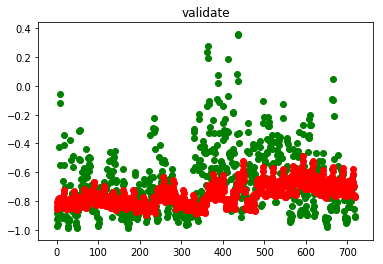

In [24]:
results=model.predict([valid_data['hour'] ,valid_data['weekday'],valid_data['month'],valid_continuas])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

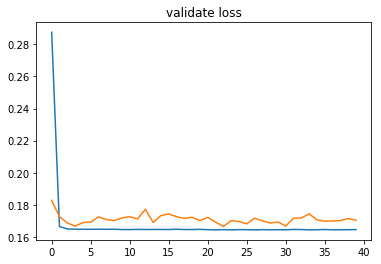

In [25]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

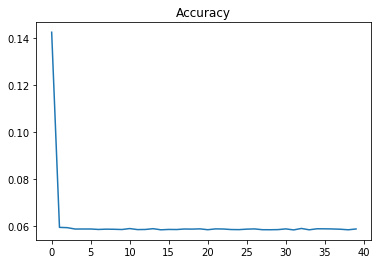

In [26]:
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [27]:
compara = pd.DataFrame(np.array([valid_target, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head()
             

,real,prediccion,diferencia
0,9.100000,11.236277,-2.136276
1,5.999999,12.425042,-6.425044
2,2.199999,15.064209,-12.864210
3,3.200001,16.291883,-13.091883
4,7.000000,15.545800,-8.545800


In [28]:
compara2.describe()

,real,prediccion,diferencia
count,720.000000,720.000000,720.000000
mean,26.078472,18.602102,7.476369
std,17.323177,5.897472,16.508499
min,1.000001,7.992404,-25.408974
25%,12.775001,13.910999,-4.025149
50%,23.249998,17.919578,4.143978
75%,35.400002,22.799438,16.720220
max,104.099998,39.317711,76.328323


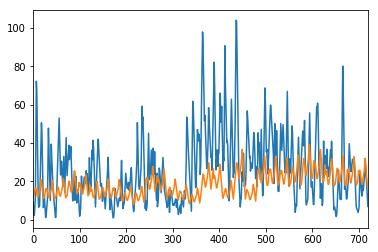

In [29]:
compara2['real'].plot()
compara2['prediccion'].plot()

In [30]:
# A partir  de los ultimos 10 dias predecimos las siguientes 48 horas
ultimosDias = df4['2019-01-05 18:00:00':'2019-10-05 20:00:00']
ultimosDias.head()

,NO2,weekday,month,hour
Fecha Lectura,,,,
2019-02-01 00:00:00,43.9,4,2,0
2019-02-01 01:00:00,37.1,4,2,1
2019-02-01 02:00:00,32.3,4,2,2
2019-02-01 03:00:00,28.3,4,2,3
2019-02-01 04:00:00,27.7,4,2,4


In [31]:
# preperamos los datos para el test
# load dataset
values = ultimosDias['NO2'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['hour']=ultimosDias['hour']
reframed['weekday']=ultimosDias['weekday']
reframed['month']=ultimosDias['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['hour'].loc[contador]=ultimosDias['hour'][i+25]
    reframed['weekday'].loc[contador]=ultimosDias['weekday'][i+8]
    reframed['month'].loc[contador]=ultimosDias['month'][i+8]
    contador=contador+1
reframed.head()

reordenado=reframed[ ['hour','weekday','month','var1(t-10)','var1(t-9)','var1(t-8)','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)'] ]
reordenado.dropna(inplace=True)
reordenado

C:\Python\envs\Corunna\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Python\envs\Corunna\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,hour,weekday,month,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
0,8.0,4.0,2.0,-0.359592,-0.458789,-0.528811,-0.587163,-0.595915,-0.674690,-0.539023,-0.582786,-0.415026,-0.194748
1,9.0,4.0,2.0,-0.458789,-0.528811,-0.587163,-0.595915,-0.674690,-0.539023,-0.582786,-0.415026,-0.194748,0.485047
2,10.0,4.0,2.0,-0.528811,-0.587163,-0.595915,-0.674690,-0.539023,-0.582786,-0.415026,-0.194748,0.485047,0.269147
3,11.0,4.0,2.0,-0.587163,-0.595915,-0.674690,-0.539023,-0.582786,-0.415026,-0.194748,0.485047,0.269147,-0.258935
4,12.0,4.0,2.0,-0.595915,-0.674690,-0.539023,-0.582786,-0.415026,-0.194748,0.485047,0.269147,-0.258935,-0.407732
5,13.0,4.0,2.0,-0.674690,-0.539023,-0.582786,-0.415026,-0.194748,0.485047,0.269147,-0.258935,-0.407732,-0.622174
6,14.0,4.0,2.0,-0.539023,-0.582786,-0.415026,-0.194748,0.485047,0.269147,-0.258935,-0.407732,-0.622174,-0.698031
7,15.0,4.0,2.0,-0.582786,-0.415026,-0.194748,0.485047,0.269147,-0.258935,-0.407732,-0.622174,-0.698031,-0.734500
8,16.0,4.0,2.0,-0.415026,-0.194748,0.485047,0.269147,-0.258935,-0.407732,-0.622174,-0.698031,-0.734500,-0.630926
9,17.0,4.0,2.0,-0.194748,0.485047,0.269147,-0.258935,-0.407732,-0.622174,-0.698031,-0.734500,-0.630926,-0.521517


In [32]:
values = reordenado.values
x_test = values[5:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ulthora = reordenado.hour[len(reordenado.index)-1]
ulthora

(2627, 1, 13)
[[[13.          4.          2.         ... -0.25893515 -0.40773165
   -0.62217361]]

 [[14.          4.          2.         ... -0.40773165 -0.62217361
   -0.69803065]]

 [[15.          4.          2.         ... -0.62217361 -0.69803065
   -0.73450041]]

 ...

 [[14.          6.          5.         ... -0.89059079 -0.90663749
   -0.81327498]]

 [[15.          6.          5.         ... -0.90663749 -0.81327498
   -0.59591544]]

 [[16.          6.          5.         ... -0.81327498 -0.59591544
   -0.55506933]]]


16.0

In [33]:

def agregarNuevoValor(x_test,nuevoValor,ulthora):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i+2] = x_test[0][0][i+3]
    ulthora=ulthora+1
    if ulthora>23:
        ulthora=0
    x_test[0][0][0]=ulthora
    x_test[0][0][1]=7
    x_test[0][0][2]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ulthora

In [34]:
# Pronóstico para la próximas 48 horas
results=[]
for i in range(49):
    hora=np.array([x_test[0][0][0]])
    dia=np.array([x_test[0][0][1]])
    mes=np.array([x_test[0][0][2]])
    valores=np.array([x_test[0][0][3:13]])
    parcial=model.predict([hora,dia, mes, valores])
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ulthora=agregarNuevoValor(x_test,parcial[0],ulthora)

pred 0 [[[13.          4.          2.         ... -0.25893515 -0.40773165
   -0.62217361]]

 [[14.          4.          2.         ... -0.40773165 -0.62217361
   -0.69803065]]

 [[15.          4.          2.         ... -0.62217361 -0.69803065
   -0.73450041]]

 ...

 [[14.          6.          5.         ... -0.89059079 -0.90663749
   -0.81327498]]

 [[15.          6.          5.         ... -0.90663749 -0.81327498
   -0.59591544]]

 [[16.          6.          5.         ... -0.81327498 -0.59591544
   -0.55506933]]]
pred 1 [[[17.          7.         12.         ... -0.40773165 -0.62217361
   -0.89006978]]

 [[14.          4.          2.         ... -0.40773165 -0.62217361
   -0.69803065]]

 [[15.          4.          2.         ... -0.62217361 -0.69803065
   -0.73450041]]

 ...

 [[14.          6.          5.         ... -0.89059079 -0.90663749
   -0.81327498]]

 [[15.          6.          5.         ... -0.90663749 -0.81327498
   -0.59591544]]

 [[16.          6.          5.         

In [35]:
#Reconvertimos los resultados
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.8900698], dtype=float32), array([-0.7611033], dtype=float32), array([-0.7433771], dtype=float32), array([-0.7457841], dtype=float32), array([-0.78416103], dtype=float32), array([-0.7789911], dtype=float32), array([-0.8095354], dtype=float32), array([-0.81677985], dtype=float32), array([-0.8118034], dtype=float32), array([-0.7802345], dtype=float32), array([-0.79187626], dtype=float32), array([-0.7820673], dtype=float32), array([-0.74783474], dtype=float32), array([-0.7258328], dtype=float32), array([-0.67855585], dtype=float32), array([-0.70109075], dtype=float32), array([-0.74773926], dtype=float32), array([-0.7722612], dtype=float32), array([-0.82010776], dtype=float32), array([-0.8292026], dtype=float32), array([-0.82078767], dtype=float32), array([-0.8301295], dtype=float32), array([-0.81212735], dtype=float32), array([-0.772203], dtype=float32), array([-0.7531862], dtype=float32), array([-0.7611033], dtype=float32), array([-0.7433771], dtype=float32), array([-0.7457841]

array([[ 7.53571679],
       [16.37637153],
       [17.59150143],
       [17.42650059],
       [14.79576208],
       [15.15016067],
       [13.0563501 ],
       [12.55974181],
       [12.90087757],
       [15.06492474],
       [14.26688336],
       [14.93928744],
       [17.28592933],
       [18.79416117],
       [22.03499789],
       [20.49022995],
       [17.29247494],
       [15.61149539],
       [12.33161383],
       [11.7081629 ],
       [12.28500598],
       [11.64462309],
       [12.87867071],
       [15.61548323],
       [16.9190851 ],
       [16.37637153],
       [17.59150143],
       [17.42650059],
       [14.79576208],
       [15.15016067],
       [13.0563501 ],
       [12.55974181],
       [12.90087757],
       [15.06492474],
       [14.26688336],
       [14.93928744],
       [17.28592933],
       [18.79416117],
       [22.03499789],
       [20.49022995],
       [17.29247494],
       [15.61149539],
       [12.33161383],
       [11.7081629 ],
       [12.28500598],
       [11

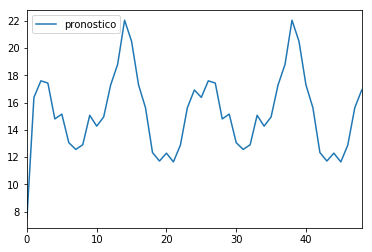

In [36]:
# Visualizamos el pronóstico 
prediccion48h = pd.DataFrame(inverted)
prediccion48h.columns = ['pronostico']
prediccion48h.plot()


In [37]:
prediccion48h.head()

,pronostico
0,7.535717
1,16.376372
2,17.591501
3,17.426501
4,14.795762


In [45]:
from datetime import datetime
a=pd.date_range(start=datetime.now(), periods=49, freq='H')
#a

In [46]:
pro= pd.DataFrame(a)

In [47]:
pro['pronostico']=prediccion48h


In [41]:
#pro['longitud']=-8.4020996

In [42]:
#pro['latitud']=43.3684616

In [48]:
#cambiar el nombre a una columna
pro.rename(columns={0:'fecha'},inplace=True)

In [49]:
pro.head()

,fecha,pronostico
0,2019-05-10 14:40:57.275332,7.535717
1,2019-05-10 15:40:57.275332,16.376372
2,2019-05-10 16:40:57.275332,17.591501
3,2019-05-10 17:40:57.275332,17.426501
4,2019-05-10 18:40:57.275332,14.795762


In [50]:
# Guardamos la predicción en un csv
pro.to_csv("C:/Users/FranciscoJosé/Documents/MySite/app3/Santa_Margarita_pre.csv")